<a href="https://colab.research.google.com/github/nekotanku/colab/blob/master/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
#前処理
transform = transforms.Compose([
     transforms.ToTensor()
])

In [5]:
#dataset download
train_dataset = datasets.MNIST(root="./data",  train=True, download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
#dataloader 
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [7]:
#model create
class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        #解像度を落とす：maxpooling
        self.en = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        #元に戻す：Upsample
        self.de = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, padding=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x=self.en(x)
        x=self.de(x)
        return x

In [8]:
model = ConvAE()
model.to(device)

ConvAE(
  (en): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (de): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
num_epochs = 15
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, imgs)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader)
    losses.append(running_loss)
    print("epoch: {}, loss: {} ".format(epoch, running_loss))


epoch: 0, loss: 0.012957672141244015 
epoch: 1, loss: 0.006805981243898471 
epoch: 2, loss: 0.0058420849805076915 
epoch: 3, loss: 0.005348029117782911 
epoch: 4, loss: 0.005024520338823398 
epoch: 5, loss: 0.004787242091695468 
epoch: 6, loss: 0.004601421200980743 
epoch: 7, loss: 0.0044670860397318995 
epoch: 8, loss: 0.00436126788991193 
epoch: 9, loss: 0.004275438018143177 
epoch: 10, loss: 0.004206435432533423 
epoch: 11, loss: 0.004143001528208455 
epoch: 12, loss: 0.004081531708439191 
epoch: 13, loss: 0.004027028824513158 
epoch: 14, loss: 0.003985848933955033 


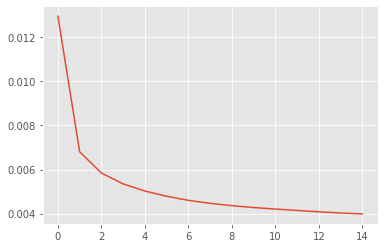

In [11]:
plt.style.use("ggplot")
plt.plot(losses)

In [12]:
data_iter = iter(train_loader)
imgs, _ = data_iter.next()
img = imgs[0]

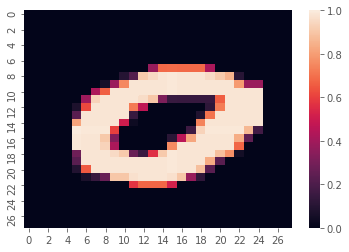

In [13]:
img_permute = img.permute(1, 2, 0)
sns.heatmap(img_permute[:, :, 0])

In [14]:
x_en = model.en(imgs.to(device))

In [16]:
x_en2 = x_en[0].permute(1,2,0)

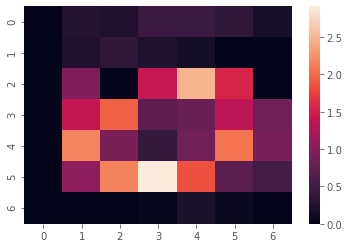

In [17]:
sns.heatmap(x_en2[:, :, 0].detach().to("cpu"))

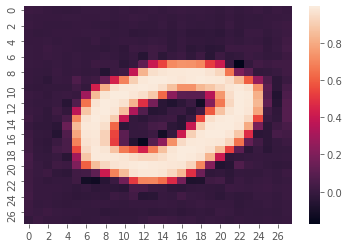

In [20]:
x_ae = model(imgs.to(device))
sns.heatmap(x_ae[0].permute(1, 2, 0).detach().to("cpu")[:, :, 0])